# WISER SIMS Data Extraction Question Distribution Analysis

This takes standard SIMS Data Extraction files and a creates a distribution of the answers for a selected questions and plots it.
- Author  : John Lutz <lutzjw@upmc.edu>
- Created : 2020-02-25
- Edited : 2020-02-25

## Some Assumptions
- You are using an unaltered SIMS data extraction file
- The question must be a multiple choice question of some type (Likert, Selection, etc)
- You have an `Analysis/Q-Distribution` directory in the folder your are running this Jupyter notebook. This is where the analysis files will go.

## Instructions

- Change the variables in the section below. The ones you will need to always change are:
    - `file`
        - Get the Data Extraction file from SIMS
            - This is the Excel file straight from SIMS Data Extraction
            - You need to have selected "Correctness" for the "Quiz Reponses" when you generate the file
            - Drag it from your computer and drop it into the file browser in Jupyter (just to the left here)
            - Right click on the file and select "Copy path" from the data file you want and paste it into the `file` variable below
    - `startNumber`, `colDiff`
        - Most data extraction files have the pre and post questions in the same order, and it's just a matter of finding the starting column "Q" number and the columns difference between the pre and the post. So if your Pre Survey questions you want to compare start at Q18 and your equivelant Post Survey starts at Q38, `startNumber=18` and `colDiff=20`. 
    - `Q1`, `Q2`
        - They should be likert scales.
        - If your questions are equally spaced Pre vs Post (or whatever), you can just set `startNumber` and `colDiff` and these will be calculated. Otherwise the first items should be "Q#" (e.g. "Q18"). 
        - Make sure there are double quotes around the IDs: "Q23"
        - The second value is what you wan the legend to be labeled (e.g. "Pre")
        - Don't forget the asteriks if appliccable for retired questions (e.g. "*Q24")
        - _Both of these questions need to be on the same scale for this to make sense_
    - `likertMax`
        - This is the maximum value you can select for this liker (typically 5 or 9)
    - `runANOVA`
        - Set this if you want to run an ANOVA analysis on these two datasets
- Once you have made your changes hit the **SHIFT-RETURN** keys together to run the analysis
- Scroll to the bottom to see the results

ANOVA       = 840.357552
P-Value     =  0.000000
(Actual PValue : 1.3112935149449603e-167
Output File : Analysis/Q-Distribution/NUR-1121-Since-2010-Q-Distribution-Q2-Q30.pdf


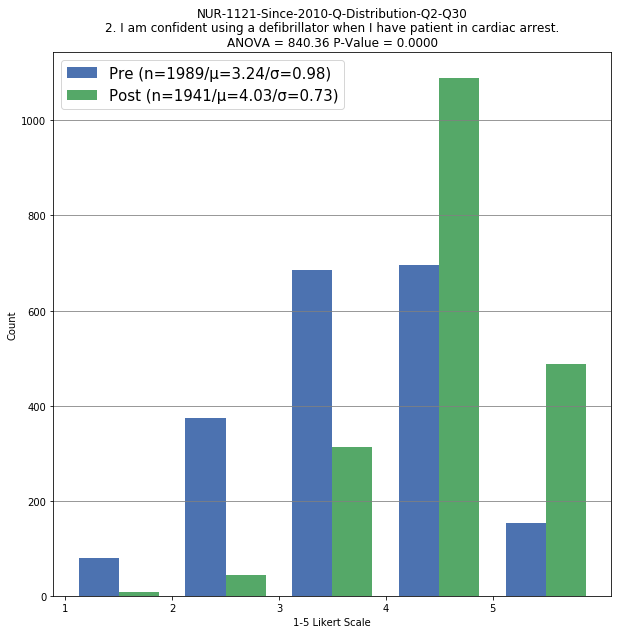

In [2]:
myJupyterLocation = '/Users/johnlutz/Library/Mobile Documents/com~apple~CloudDocs/Code/Jupyter Notebooks/'

file = "WISER/data/NUR1121/NUR-1121-Since-2010.xlsx"
#Put the first and second Question IDs here.
startNumber = 2
colDiff    = 28

Q1 = ["Q"+str(startNumber),         "Pre"]
Q2 = ["Q"+str(startNumber+colDiff), "Post"]

#Use this if the questions are note evently spaced:
#Q1 = ["Q22", "Pre"]
#Q2 = ["Q32", "Pre"]

likertMax = 5
runANOVA = True

####################################################################
#  This is the end of the section where you can change variables   #
####################################################################
%matplotlib inline
import pandas as pd
#from scipy import stats
import math
import os
#from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

#set the 
fileLabel = Q1[0]+'-'+Q2[0]

#Add my home directory to the path and get the base file name
file = myJupyterLocation + file
base = os.path.basename(file)
fileName=os.path.splitext(base)[0]

# Open up the Excel File
xl = pd.ExcelFile(file)

#Find the Question Text
qSheet = xl.parse('Question Dictionary', index_col="Q#")
qText = qSheet.loc[Q1[0]].Text
        
ds = xl.parse('User') # The User sheet holds the data by default.
ds['ClsDate'] = pd.to_datetime(ds['ClsDate']) #change string to real datatime

q1Results = ds[Q1[0]].replace(-999).dropna()
q2Results = ds[Q2[0]].replace(-999).dropna()

#Start the plotting...
plt.style.use('seaborn-deep') #Nice dark style - seaborn-deep
fig, axs = plt.subplots(1,1)
#create the histograms
axs.hist([q1Results,q2Results], bins=np.arange(1, likertMax+2, 1), rwidth=0.75, label=[Q1[1], Q2[1]])

#set the chart size (in inches)
fig.set_size_inches(10,10)

#Set the number of ticks on the X axis
plt.xticks(np.arange(1, likertMax+1, 1))
#turn on the grid
plt.grid(b=True, axis='y', color='gray')

#Get the text for the legend
q1Stats = q1Results.describe()
q1Str  = Q1[1]+" (n={:.0f}/".format(q1Stats[0]) #Count
q1Str  = q1Str+"μ={:4.2f}/".format(q1Stats[1]) #Mean
q1Str  = q1Str+"σ={:4.2f})".format(q1Stats[2]) #StdDev

q2Stats = q2Results.describe()
q2Str  = Q2[1]+" (n={:.0f}/".format(q2Stats[0]) #Count
q2Str  = q2Str+"μ={:4.2f}/".format(q2Stats[1]) #Mean
q2Str  = q2Str+"σ={:4.2f})".format(q2Stats[2]) #StdDev

aNovaStr = ""
if (runANOVA):
    aNova = stats.f_oneway(q1Results, q2Results)
    aNovaStr =  "\nANOVA = {0:6.2f}".format(aNova.statistic)
    aNovaStr += " P-Value = {0:5.4f}".format(aNova.pvalue)
    
plt.legend([q1Str, q2Str], loc='upper left', fontsize=15)
axs.set_title(fileName+ '-Q-Distribution-' +fileLabel+ "\n" +qText +aNovaStr)
axs.set_ylabel("Count")
axs.set_xlabel("1-" +str(likertMax)+ " Likert Scale")

outFileStr = 'Analysis/Q-Distribution/' +fileName+'-Q-Distribution-'+fileLabel+'.pdf'
if (runANOVA):
    print ("ANOVA       = {0:9.6f}".format(aNova.statistic))
    print ("P-Value     = {0:9.6f}".format(aNova.pvalue))
    if (aNova.pvalue < 0.00001): #Print the raw data if we have a tiny P value
        print ("(Actual PValue : " +str(aNova.pvalue))
    
print ('Output File : ' +outFileStr)
plt.savefig(outFileStr)
